In [5]:
# Run this cell first to import some modules
# we'll need to run the examples below.
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from pydrake.multibody.rigid_body_tree import (
    RigidBodyTree,
    FloatingBaseType
)
from pydrake.multibody.rigid_body_plant import (
    RigidBodyPlant
)
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import (
    Context,
    DiagramBuilder,
    LeafSystem,
    PortDataType,
    BasicVector
)
from pydrake.systems.primitives import (
    SignalLogger
)
from underactuated import ( FindResource, ManipulatorDynamics, PlanarRigidBodyVisualizer )

In [6]:
# This cell sets up a double pendulum, runs a simulation, and
# renders a video of its results.

# Load the double pendulum from Universal Robot Description Format
tree = RigidBodyTree(FindResource("double_pendulum/double_pendulum.urdf"), FloatingBaseType.kFixed)

# Set up a block diagram with the robot (dynamics) and a logger block.
builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))
builder.ExportInput(robot.get_input_port(0))

# The logger needs to be told to expect a 4-element input
# (the 4-element double pendulum state, in this case).
logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(robot.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

# Set the initial conditions
context = simulator.get_mutable_context()
context.FixInputPort(0, BasicVector([0.,0.]))   # Zero input torques
state = context.get_mutable_continuous_state_vector()
state.SetFromVector((2.,0.5,0.2,0.0))  # (theta1, theta2, theta1dot, theta2dot)

# Simulate
simulator.StepTo(10.0)

# Visualize the result as a video.
vis = PlanarRigidBodyVisualizer(tree, xlim=[-3.4,3.4], ylim=[-3.4,3.4], use_random_colors=True)
ani = vis.animate(logger, repeat=True)
plt.close(vis.fig)
HTML(ani.to_html5_video())

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Spawning PlanarRigidBodyVisualizer for tree with 2 actuators


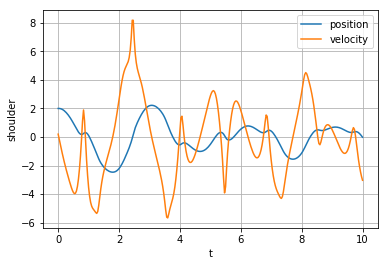

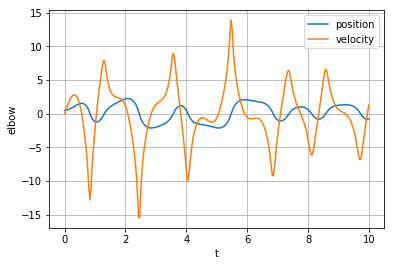

In [7]:
# Run this cell after running a simulation to plot traces
# of the pendulum state across time.
fields = ["shoulder", "elbow"]
for i in range(2):
    #plt.subplot(3, 1, i+1)
    plt.plot(logger.sample_times(), logger.data()[(i, i+2), :].transpose())
    plt.legend(["position", "velocity"])
    plt.xlabel('t')
    plt.ylabel(fields[i])
    plt.grid(True)
    plt.show()